<p>
<img src="./nlp/imgs/EII-ULPGC-logo.jpeg" width="430px" align="right">

# **Tutorial de Pytorch 8:  clasificador dataset MNIST utilizando capas convolucionales**

Habiendo hecho la red neuronal *fully connected* en el tutorial anterior, ahora vamos a usar las capas convolutivas para clasificar el dataset MNIST haciendo uso de PyTorch.


In [ ]:
import torch
SEED = 42  # Puedes elegir cualquier número entero

# Semilla para PyTorch
torch.manual_seed(SEED)

# Semilla para CUDA (si estás usando GPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

# Semilla para NumPy
#np.random.seed(SEED)

# Semilla para random de Python
#random.seed(SEED)

# Configuración adicional para reproducibilidad en CUDA
torch.backends.cudnn.deterministic = True


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Definimos las transformaciones para normalizar los datos
# Las imágenes originales están en escala de grises con valores entre 0.0 y 1.0
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertimos imágenes a Tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizamos con media 0.5 y desviación estándar 0.5
])

# Cargamos el dataset MNIST
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  #Los minilotes se construyen repartiendo las muestras aleatoriamente. En cada época los minilotes cambian (se vuelven a repartir)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False) #Los minilotes se construyen sin barajar las muestras. En cada época los minilotes son siempre los mismos.


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 503kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]


Definiremos una clase para nuestra red convolutiva. Esta red tendrá dos capas convolutivas seguidas de dos capas lineales (fully connected). Usaremos ReLU como nuestra función de activación y aplicaremos max pooling después de cada capa convolutiva.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)  # Entrada: 1 canal, Salida: 16 canales, kernel de 5x5
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling con un kernel de 2x2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)  # Entrada: 16 canales, Salida: 32 canales >> N, 16, 14, 14 -> N, 32, 14, 14
        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Imágenes reducidas a 7x7 después del pooling
        self.fc2 = nn.Linear(120, 10)  # 10 clases de salida para MNIST

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # >> N, 1, 28, 28 -> N, 16, 28, 28 -> N, 16, 14, 14
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x))) # >> N, 16, 14, 14 -> N, 16, 7, 7 -> N, 32, 7, 7
        #print(x.shape)
        x = x.view(-1, 32 * 7 * 7)  # Aplanamos el tensor para la capa lineal
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = self.fc2(x)
        return x


Para entrenar la red, necesitamos definir una función de pérdida y un optimizador. Usaremos la entropía cruzada como nuestra función de pérdida y el optimizador Adam.

In [ ]:
import torch.optim as optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ConvNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:

# Entrenamiento
model.train()

epochs = 5
for epoch in range(epochs):
    epoch_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Pasamos las imágenes por la red
        loss = loss_fn(outputs, labels)  # Calculamos la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos los pesos
        optimizer.zero_grad()  # Limpiamos los gradientes

        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}')


Epoch 1, Loss: 0.17269845542484033
Epoch 2, Loss: 0.04913876465246725
Epoch 3, Loss: 0.03374886884031865
Epoch 4, Loss: 0.026209832924015537
Epoch 5, Loss: 0.02003755559116219


Después del entrenamiento, evaluamos el rendimiento del modelo en el conjunto de prueba.

In [ ]:
correct = 0
total = 0

model.eval()
with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10000 test images: {100 * correct / total}%')


Accuracy of the model on the 10000 test images: 99.19%


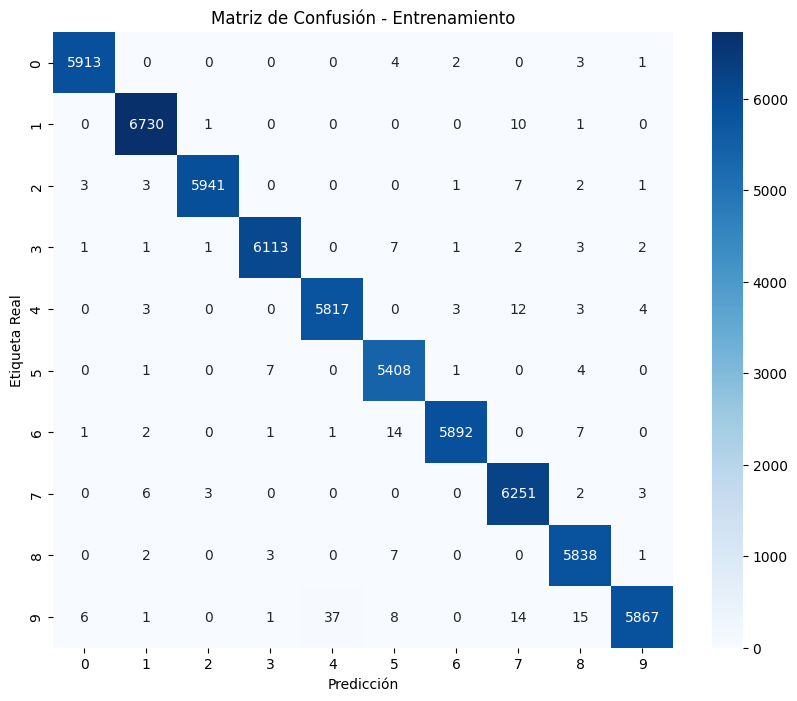

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds_train = []
all_labels_train = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds_train.extend(predicted.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

conf_matrix_train = confusion_matrix(all_labels_train, all_preds_train)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()


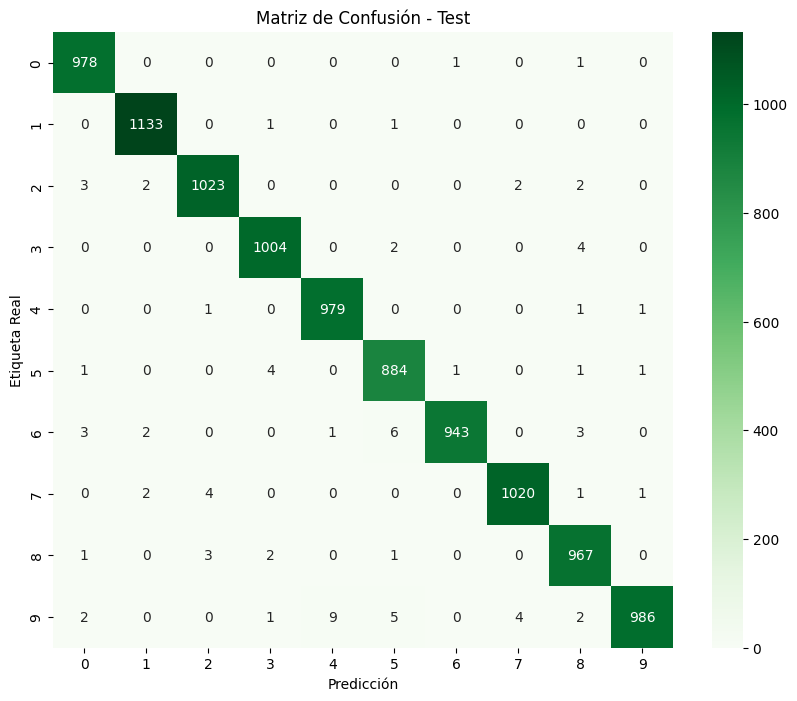

In [ ]:
model.eval()

all_preds_test = []
all_labels_test = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds_test.extend(predicted.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

conf_matrix_test = confusion_matrix(all_labels_test, all_preds_test)

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Test')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Reporte de clasificación para el conjunto de test:")
print(classification_report(all_labels_test, all_preds_test))

Reporte de clasificación para el conjunto de test:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
# Entrenamiento

model.train()
epochs = 5

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    epoch_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validación
    correct_val = 0
    total_val = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracies.append(100 * correct_val / total_val)

    print(f'Epoch {epoch+1}, Loss: {train_losses[-1]}, Train Acc: {train_accuracies[-1]}%, Val Acc: {val_accuracies[-1]}%')

Epoch 1, Loss: 0.18235573983976622, Train Acc: 94.525%, Val Acc: 98.32%
Epoch 2, Loss: 0.04963187251670925, Train Acc: 98.48666666666666%, Val Acc: 98.03%
Epoch 3, Loss: 0.03562143924613811, Train Acc: 98.92666666666666%, Val Acc: 98.91%
Epoch 4, Loss: 0.027229933798684106, Train Acc: 99.13166666666666%, Val Acc: 99.0%
Epoch 5, Loss: 0.02127197155992236, Train Acc: 99.34833333333333%, Val Acc: 99.17%


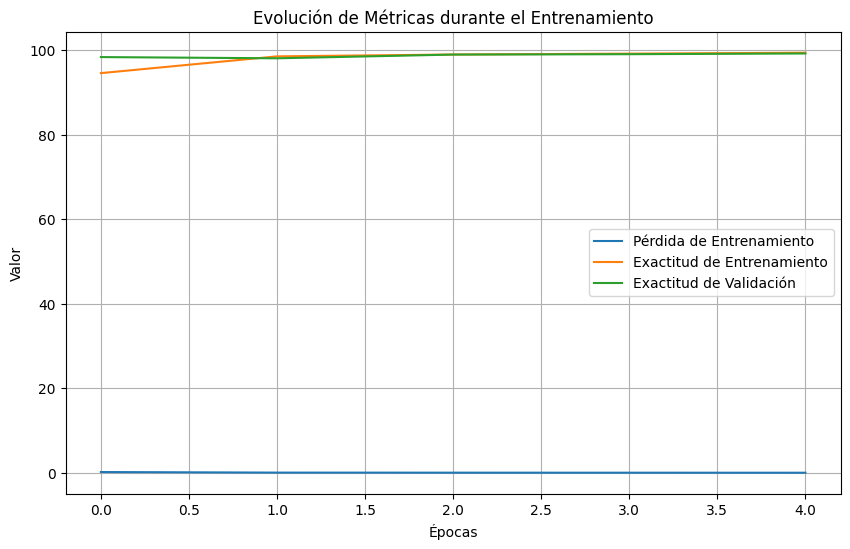

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(train_accuracies, label='Exactitud de Entrenamiento')
plt.plot(val_accuracies, label='Exactitud de Validación')
plt.xlabel('Épocas')
plt.ylabel('Valor')
plt.title('Evolución de Métricas durante el Entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Guardamos los pesos del modelo
torch.save(model.state_dict(), 'modelo_mnist.pth')
print("Modelo guardado como 'modelo_mnist.pth'")

Modelo guardado como 'modelo_mnist.pth'


In [ ]:
torch.save(model, 'modelo_completo_mnist.pth')

In [ ]:
model = ConvNet().to(device)
model.load_state_dict(torch.load('modelo_mnist.pth'))
model.eval()  # Muy importante para desactivar dropout/batchnorm si los hubiera
print("Modelo cargado y listo para evaluación.")

In [ ]:
model = torch.load('modelo_completo_mnist.pth')
model.to(device)
model.eval()
print("Modelo completo cargado.")